## Big Data ICP10

#### Deep Q Learning - 
CartPole is one of the simplest environments in the OpenAI gym (a game simulator). The idea of CartPole is that there is a pole standing up on top of a cart. The goal is to balance this pole by moving the cart from side to side to keep the pole balanced upright.

#### The objective of the analysis-

* Design a Deep Q learning Network (DQN), using Keras & OpenAl Gym, for cartpole game and visualize your results.
* Visualization of DQN Cartpole game.

#### About Cartpole Game
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

More information about cartpole
https://gym.openai.com/envs/CartPole-v1/

#### Do All the necessary installations

In [71]:
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym

### Import libraries

In [90]:
from pyvirtualdisplay import Display

from IPython import display
import gym 
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
from random import shuffle

from gym import wrappers
from keras.models import Sequential, load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from collections import deque

The Gym library by OpenAI provides virtual environment that can be used to compare performances of different reinforcement learning techniques.

I will be using the CartPole Environment form the OpenAI Gym Library.

Let's start by creating the environment and getting some useful information about the environment.

In [105]:
env = gym.make('CartPole-v1')

In [106]:
env.reset()
for _ in range(1000):
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)
  env.render()
env.close()

In [93]:
# Environment Information
env.reset()
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))
print("High Observation Space {}".format(env.observation_space.high))
print("Low Observation Space {}".format(env.observation_space.low))

Action Space Discrete(2)
State Space Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
High Observation Space [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Low Observation Space [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


There are 2 possible actions that can be performed at each time step: move the cart to the left (0) or to the right (1). There are 4 states that can be observed at each time step: 
* the position of the cart
* its velocity 
* the angle of the pole  
* the velocity of the pole at the tip

next_state, reward, done, info = env.step(action)

As we discussed above, action can be either 0 or 1. If we pass those numbers, env, which represents the game environment, will emit the results. done is a boolean value telling whether the game ended or not. The old state information paired with action and next_state and reward is the information we need for training the agent.

## Hyper Parameters

There are some parameters that have to be passed to a reinforcement learning agent. You will see these over and over again.

* episodes - a number of games we want the agent to play.
* gamma - aka decay or discount rate, to calculate the future discounted reward.
* epsilon - aka exploration rate, this is the rate in which an agent randomly decides its action rather than prediction.
* epsilon_decay - we want to decrease the number of explorations as it gets good at playing games.
* epsilon_min - we want the agent to explore at least this amount.
* learning_rate - Determines how much neural net learns in each iteration.

In [97]:
ACTIONS_DIM = 2 ## Output Dimension=No. of possible actions (2)
OBSERVATIONS_DIM = 4 ## Input Dimension= No of Elements in State Tuple (4)
MAX_ITERATIONS = 200 ## Max Time Steps Per Game (Limited to 200 by Environment)
LEARNING_RATE = 0.01
NUM_EPOCHS = 50

GAMMA = 0.99 ## Future Reward Discount Factor
REPLAY_MEMORY_SIZE = 10000 ## Replay Memory Size
NUM_EPISODES = 100 ## Games Played in Training Phase
MINIBATCH_SIZE = 32 ## Number of Samples chosen randomly from Replay Memory

RANDOM_ACTION_DECAY = 0.99 ## The factor by which Random Action Probability Decreases
INITIAL_RANDOM_ACTION = 1 ## Initial Random Action Factor
Samples=[] ## A list to store Individual Game Scores
Means=[] ##A list to store Mean Score over Last 20 Games

## Class and Functions

Here I have defined a class and few functions.

ReplayBuffer - A class is defined for replay memory which has a data structure of dqueue type with maximum length of REPLAY_MEMORY. SIZE (initialised above).

get_q - A function to Predict Q-Values from the Model.
train - A function to Train the Model

predict - A function to predict Q values form model
get_model - A function to build the Deep Q-Network
update_action - A function to update the model

Model Details - We will have one input layer that receives 4 information and 3 hidden layers. But we are going to have 2 nodes in the output layer since there are two buttons (0 and 1) for the game. Memorize One of the challenges for DQN is that neural network used in the algorithm tends to forget the previous experiences as it overwrites them with new experiences. So we need a list of previous experiences and observations to re-train the model with the previous experiences.

Replay A method that trains the neural net with experiences in the memory is called replay. First, we sample some experiences from the memory and call them minibatch.

To make the agent perform well in long-term, we need to take into account not only the immediate rewards but also the future rewards we are going to get. In order to do this, we are going to have a ‘discount rate’ or ‘gamma’. This way the agent will learn to maximize the discounted future reward based on the given state.

In [98]:
class ReplayBuffer():
  def __init__(self, max_size):
    self.max_size = max_size
    self.transitions = deque()

  def add(self, observation, action, reward, observation2):
    if len(self.transitions) > self.max_size:
      if np.random.random() < 0.5:
        shuffle(self.transitions)
      self.transitions.popleft()
    self.transitions.append((observation, action, reward, observation2))

  def sample(self, count):
    return random.sample(self.transitions, count)

  def size(self):
    return len(self.transitions)

def get_q(model, observation):
  np_obs = np.reshape(observation, [-1, OBSERVATIONS_DIM])
  return model.predict(np_obs)

def train(model, observations, targets):
  np_obs = np.reshape(observations, [-1, OBSERVATIONS_DIM])
  np_targets = np.reshape(targets, [-1, ACTIONS_DIM])

  model.fit(np_obs, np_targets, epochs =1, verbose = 0)

def predict(model, observation):
  np_obs = np.reshape(observation, [-1, OBSERVATIONS_DIM])
  return model.predict(np_obs)

def get_model():
  model = Sequential()
  model.add(Dense(24, input_shape = (OBSERVATIONS_DIM, ), activation= 'relu'))
  model.add(Dense(24, activation= 'relu'))
  model.add(Dense(2, activation= 'linear'))

  model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=[], )

  return model

def update_action(action_model, target_model, sample_transitions): ## Update the model
    random.shuffle(sample_transitions) ## Randomly Shuffle the Minibatch Samples
    batch_observations = [] ## Initialize State(Observation) List
    batch_targets = [] ## Initialize Target(Output Label) List

    for sample_transition in sample_transitions: ## For each sample in Minibatch
        ## Separate*each part of observation
        old_observation, action, reward, observation = sample_transition

        ####
        ## Reshape targets to output dimension(=2)
        ####
        targets = np.reshape(get_q(action_model, old_observation), ACTIONS_DIM)
        targets[action] = reward ## Set Target Value

        if observation is not None: ## If observation is not Empty    
            ## Query the Model for possible actions and corresponding Q-Values
            predictions = predict(target_model, observation)
            new_action = np.argmax(predictions) ## Select the Best Action (Max Q-Value)
            ## Update the Target with Future Reward Discount Factor
            targets[action] += GAMMA * predictions[0, new_action]

        batch_observations.append(old_observation) ## Add Old State to observations batch
        batch_targets.append(targets) ## Add target to targets batch

    ## Update the model using Observations and their corresponding Targets
    train(action_model, batch_observations, batch_targets)

## Main Program Logic

In this learning, we have 200 game limits as NUM_EPISODES to train the model and for each game we have 500 time steps as MAX_ITERATIONS.

This program holds score of last 50 games. If average of game score for last 50 games is more than 195 and iteration is more than 195, It means learning is
done and model is converged.

Starting of each game, We check whether model is converged or not and then proceed. If not converged, following steps are taken.

* Reduce the Random Action Probability by Decay Factor
* Reset the Environment after Each Game

Now we will iterate over time steps for each game.

* Generate Random Action Probability
* Store Current State
* Generate random action and if it is less than Random Action Probability, we take it as action else we query the model and Get Q-Values for possible actions and select the best action using Q-Values received and observe next state.
* Check if game is over
    * Add Final Score of the Game to the Score List.
    * If Number of Games>50, Calculate Mean Over 50 Games to Check Convergence
    * Print End-Of-Game Information.
    * If, game is over at last time step, Give +5 Reward for Completing the Game Successfully else Give -5 Reward for Taking Wrong Action Leading to Failure.

At the end of each time step, Observation is added in Replay Memory.

Finally Update the Deep Q-Network Model.

In [99]:
Temp=[] ## Initialize a list to hold most recent 50 Game Scores
iteration=0 ## Initialize Time Step Number to Avoid initial No variable Error
## Set Random Action Probability to Initial Number(=1)
random_action_probability = INITIAL_RANDOM_ACTION

replay = ReplayBuffer(REPLAY_MEMORY_SIZE) ## Initialize Replay Memory & Specify Maximum Capacity

action_model = get_model() ## Initialize action-value model with random weights

env = gym.make('CartPole-v1') ## Prepare the OpenAI Cartpole-v1 Environment

for episode in range(NUM_EPISODES): ## For Games 0 to Maximum Games Limit
    ## If mean over the last 50 Games is >195, then Success!!!
    if np.mean(Temp)>195 and iteration>195:
        print('Passed') ## Print the information that the model is converged
        break ## Terminate after convergence

    ## Reduce the Random Action Probability by Decay Factor
    random_action_probability *= RANDOM_ACTION_DECAY
    observation = env.reset() ## Reset the Environment after Each Game

    for iteration in range(MAX_ITERATIONS): ## Timesteps
        ## Generate Random Action Probability
        random_action_probability = max(random_action_probability, 0.1)
        old_observation = observation ## Store Current State
        ## If generated fraction<Random Action Probability
        if np.random.random() < random_action_probability:
            ## Take Random Action (Explore)
            action = np.random.choice(range(ACTIONS_DIM))
        else: ## IT generated fraction>Random Action Probability

            ## Query the Model and Get Q-Values for possible actions
            q_values = get_q(action_model, observation)
            action = np.argmax(q_values) ## Select the Best Action using Q-Values received
        ## Take the Selected Action and Observe Next State
        observation, reward, done, info = env.step(action)

        if done: ## If Game Over
            Samples.append(iteration+1) ## Add Final Score of the Game to the Scores List
            ## If Number of Games>50, Calculate Mean Over 50 Games to Check Convergence
            if len(Samples)>50:
                Temp=Samples[-50:] ## Select Score of Most Recent 50 Games
                ## Add Mean of Most Recent 20 Games to a list
                Means. append(np.mean (Samples [-20:]))
            ## Print End-Of-Game Information
            print(('Episode:{}, iterations:{}, RAP:{}'). format (episode, iteration, random_action_probability))

            if iteration!=199:
                reward = -5 ## Give -5 Reward for Taking Wrong Action Leading to Failure
            if iteration==199:
                reward= 5 ## Give +5 Reward for Completing the Game Successfully
            ## Add the Observation to Replay Memory
            replay.add(old_observation, action, reward, None)
            break ## Break and Start a new Game

        ## Add the Observation to Replay Memory
        replay.add(old_observation, action, reward, observation)

        ## Update the Deep Q-Network Model
        if replay.size() >= MINIBATCH_SIZE and np.random.random()<0.25 and Samples[-1]<195:
            sample_transitions = replay.sample(MINIBATCH_SIZE)
            update_action(action_model, action_model, sample_transitions)

Episode:0, iterations:13, RAP:0.99
Episode:1, iterations:32, RAP:0.9801
Episode:2, iterations:24, RAP:0.9702989999999999
Episode:3, iterations:12, RAP:0.96059601
Episode:4, iterations:24, RAP:0.9509900498999999
Episode:5, iterations:33, RAP:0.9414801494009999
Episode:6, iterations:13, RAP:0.9320653479069899
Episode:7, iterations:15, RAP:0.92274469442792
Episode:8, iterations:19, RAP:0.9135172474836407
Episode:9, iterations:12, RAP:0.9043820750088043
Episode:10, iterations:25, RAP:0.8953382542587163
Episode:11, iterations:11, RAP:0.8863848717161291
Episode:12, iterations:12, RAP:0.8775210229989678
Episode:13, iterations:13, RAP:0.8687458127689781
Episode:14, iterations:33, RAP:0.8600583546412883
Episode:15, iterations:11, RAP:0.8514577710948754
Episode:16, iterations:14, RAP:0.8429431933839266
Episode:17, iterations:29, RAP:0.8345137614500874
Episode:18, iterations:14, RAP:0.8261686238355865
Episode:19, iterations:44, RAP:0.8179069375972307
Episode:20, iterations:25, RAP:0.8097278682212

#### Plotting the Training models

Training Done


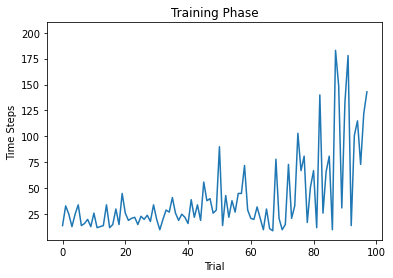

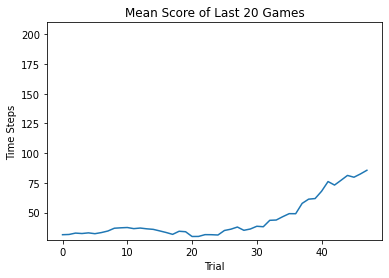

In [102]:
#Now We plot the Training Results.
print("Training Done")
plt.plot(Samples)
plt.title('Training Phase')
plt.ylabel('Time Steps')
plt.ylim(ymax=210)
plt.xlabel('Trial')
plt.savefig('Training.png', bbox_inches='tight')
plt.show()

plt.plot (Means)
plt.title('Mean Score of Last 20 Games')
plt.ylabel( 'Time Steps')
plt.ylim(ymax=210)
plt.xlabel('Trial')
plt.savefig('Training_Average.png', bbox_inches='tight')
plt.show()

#### Testing the model

143.0


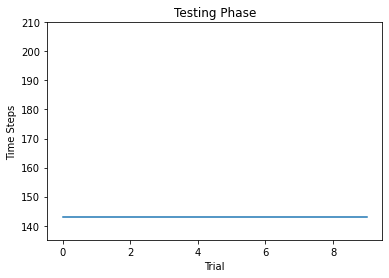

In [101]:
## Here testing the trained model for 10 more games
Tests=[] ## Initialize the Game Score List
for i in range(0,10): ## Testing for 10 Games
    observation = env.reset()
    while(True):
        old_observation = observation
        q_values = get_q(action_model, observation)
        action = np.argmax(q_values)
        observation, reward, done, info = env.step(action)
        if done:
            Tests. append(iteration+1)
            env.reset()
            break
print(np.mean(Tests))
plt.plot(Tests)
plt.title('Testing Phase')
plt.ylabel('Time Steps')
plt.ylim(ymax=210)
plt.xlabel('Trial')
plt.show()